[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y2/notebooks/DSM_ALD_2D_Mixture.ipynb)

# Score-based Diffusion (DSM + Annealed Langevin) on a 2D Two-Gaussian Mixture
## Rodolphe Cledassou School 2025

> Marc Huertas-Company & Hubert Bretonnière

This mini-notebook trains a **noise-conditional score network** on a 2D **two-component Gaussian mixture** using **Denoising Score Matching (DSM)**, and visualizes:
- the **estimated score field** \( s_\theta(x,\sigma) \) with arrows (quiver) over the true density,
- **Langevin samples** at fixed noise levels \( \sigma \),
- and **Annealed Langevin Dynamics (ALD)** samples across a decreasing sequence of \( \sigma \) values.

The goal is **illustration and intuition**, not high performance.

## 1) Imports & setup

In [ ]:
# --- EUCLID SCHOOL: LIGHT BOOTSTRAP (no data) -------------------------------
# Detect Colab, (optionally) install minimal deps, (optionally) clone the repo,
# and print device info. It does NOT download any dataset.
# ----------------------------------------------------------------------------
import os, sys, subprocess
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# --- Colab detection
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

# --- Settings (edit if needed)
INSTALL_DEPS = True                # set False if you want to skip pip installs on Colab
PIP_PKGS = [
    # Keep small. Colab already has torch + CUDA.
    "datasets==4.*", "transformers==4.*", "timm==1.*", "albumentations==2.*",
    "lightning==2.*", "pytorch-lightning==2.*", "einops==0.*",
    "pyarrow", "seaborn", "umap-learn", "nflows",
    "tensorboard", "tqdm", "safetensors", "opencv-python"
]

# If your notebook relies on repo-relative paths, you can enable this:
CLONE_REPO = False                 # set True only if needed
REPO_URL   = "https://github.com/mhuertascompany/euclid-school-2025.git"
REPO_DIR   = "/content/euclid-school-2025"
SUBDIR     = None                  # e.g., "Y1/notebooks" or "Y2/xyz"

def pip_install(pkgs):
    if not pkgs: return
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + list(pkgs)
    subprocess.run(cmd, check=True)

if IN_COLAB:
    print("Running on Google Colab ✓")
    if INSTALL_DEPS:
        print("Installing minimal pip deps…")
        pip_install(PIP_PKGS)

    if CLONE_REPO:
        if not os.path.isdir(REPO_DIR):
            print(f"Cloning {REPO_URL} …")
            subprocess.run(["git", "clone", "-q", REPO_URL, REPO_DIR], check=True)
        if SUBDIR:
            os.chdir(os.path.join(REPO_DIR, SUBDIR))
            print("Working directory:", os.getcwd())

    # Device info
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except Exception:
        pass
else:
    print("Not running on Colab (no action).")
# ----------------------------------------------------------------------------
import torch
print("\nPyTorch:", torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
import os, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

device: cpu


## 2) Target distribution: 2D two-component Gaussian mixture

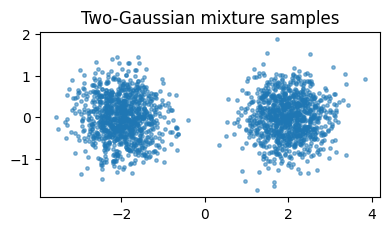

In [2]:
# Mixture params
w = torch.tensor([0.5, 0.5], dtype=torch.float32, device=device)              # weights
mus = torch.tensor([[-2.0, 0.0], [ 2.0, 0.0]], dtype=torch.float32, device=device)  # means
std = 0.5
cov = (std**2) * torch.eye(2, device=device)  # isotropic

def sample_mixture(n):
    comp = torch.multinomial(w, num_samples=n, replacement=True)  # [n]
    eps = torch.randn(n, 2, device=device) * std
    x = mus[comp] + eps
    return x

def log_gaussian(x, mu, cov):
    # cov is scalar*I here; handle generic form
    d = x.size(-1)
    inv = torch.inverse(cov)
    diff = x - mu
    quad = (diff @ inv * diff).sum(-1)
    sign, logdet = torch.slogdet(cov)
    return -0.5*(d*math.log(2*math.pi) + logdet + quad)

def log_mixture(x):
    # logsumexp over components
    L = []
    for k in range(mus.size(0)):
        L.append(torch.log(w[k]) + log_gaussian(x, mus[k], cov))
    return torch.logsumexp(torch.stack(L, dim=-1), dim=-1)

@torch.no_grad()
def true_score(x):
    # ∇_x log p(x) for a Gaussian mixture: weighted sum of component scores with responsibilities
    # score of N(mu, cov) is cov^{-1}(mu - x)
    inv = torch.inverse(cov)
    logps = []
    scores = []
    for k in range(mus.size(0)):
        logp_k = torch.log(w[k]) + log_gaussian(x, mus[k], cov)     # [B]
        logps.append(logp_k)
        scores.append((inv @ (mus[k] - x).unsqueeze(-1)).squeeze(-1))  # [B,2]
    logps = torch.stack(logps, dim=-1)           # [B,K]
    scores = torch.stack(scores, dim=-2)         # [B,K,2]
    gamma = torch.softmax(logps, dim=-1)         # responsibilities [B,K]
    s = (gamma.unsqueeze(-1) * scores).sum(dim=-2)  # [B,2]
    return s

# Visualize target samples
with torch.no_grad():
    x_demo = sample_mixture(2000).cpu().numpy()
plt.figure(figsize=(4,4))
plt.scatter(x_demo[:,0], x_demo[:,1], s=6, alpha=0.5)
plt.title("Two-Gaussian mixture samples"); plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout(); plt.show()

## 3) DSM setup: noise levels and loss

In [11]:
# Noise levels for training: log-uniform in [sigma_min, sigma_max]
sigma_min, sigma_max = 0.05, 1.0
def sample_sigma(batch):
    u = torch.rand(batch, device=device)
    logs = torch.log(torch.tensor(sigma_min, device=device))*(1-u) + torch.log(torch.tensor(sigma_max, device=device))*u
    return torch.exp(logs)

def lambda_weight(sigma):  # common balancing
    return sigma**2

# Model: small MLP score network s_theta(x, sigma)
class ScoreNet(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2+1, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, x, sigma):
        if sigma.dim()==1:
            sigma = sigma.view(-1,1)
        inp = torch.cat([x, torch.log(sigma)], dim=-1)  # condition on log sigma
        return self.net(inp)

score_net = ScoreNet(hidden=128).to(device)
opt = optim.AdamW(score_net.parameters(), lr=2e-3)

# Training data cache
N_train = 100000
train_data = sample_mixture(N_train)

def dsm_loss(x):
    B = x.size(0)
    sigma = sample_sigma(B)
    eps = torch.randn_like(x)
    xt = x + sigma.view(-1,1) * eps
    s = score_net(xt, sigma)                   # [B,2]
    target = - eps / sigma.view(-1,1)          # [B,2]
    w = lambda_weight(sigma).view(-1,1)
    loss = 0.5 * w * (s - target)**2
    return loss.sum(dim=1).mean()

## 4) Train the score model (DSM)

[ 100/10000] loss=0.7510
[ 200/10000] loss=0.7505
[ 300/10000] loss=0.7494
[ 400/10000] loss=0.7528
[ 500/10000] loss=0.7495
[ 600/10000] loss=0.7528
[ 700/10000] loss=0.7522
[ 800/10000] loss=0.7530
[ 900/10000] loss=0.7486
[1000/10000] loss=0.7480
[1100/10000] loss=0.7495
[1200/10000] loss=0.7524
[1300/10000] loss=0.7555
[1400/10000] loss=0.7568
[1500/10000] loss=0.7543
[1600/10000] loss=0.7518
[1700/10000] loss=0.7516
[1800/10000] loss=0.7475
[1900/10000] loss=0.7552
[2000/10000] loss=0.7478
[2100/10000] loss=0.7541
[2200/10000] loss=0.7504
[2300/10000] loss=0.7515
[2400/10000] loss=0.7571
[2500/10000] loss=0.7533
[2600/10000] loss=0.7477
[2700/10000] loss=0.7534
[2800/10000] loss=0.7471
[2900/10000] loss=0.7548
[3000/10000] loss=0.7549
[3100/10000] loss=0.7506
[3200/10000] loss=0.7533
[3300/10000] loss=0.7489
[3400/10000] loss=0.7525
[3500/10000] loss=0.7482
[3600/10000] loss=0.7582
[3700/10000] loss=0.7499
[3800/10000] loss=0.7480
[3900/10000] loss=0.7546
[4000/10000] loss=0.7540


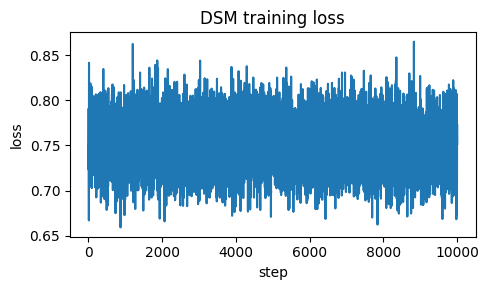

In [19]:
batch_size = 1024
steps = 10000
print_every = 100

loss_hist = []
for it in range(1, steps+1):
    idx = torch.randint(0, N_train, (batch_size,), device=device)
    x = train_data[idx]
    loss = dsm_loss(x)
    opt.zero_grad(); loss.backward(); opt.step()
    loss_hist.append(float(loss))
    if it % print_every == 0:
        print(f"[{it:4d}/{steps}] loss={np.mean(loss_hist[-print_every:]):.4f}")

plt.figure(figsize=(5,3))
plt.plot(loss_hist)
plt.title("DSM training loss"); plt.xlabel("step"); plt.ylabel("loss"); plt.tight_layout(); plt.show()

## 5) Visualize estimated score fields (quiver)

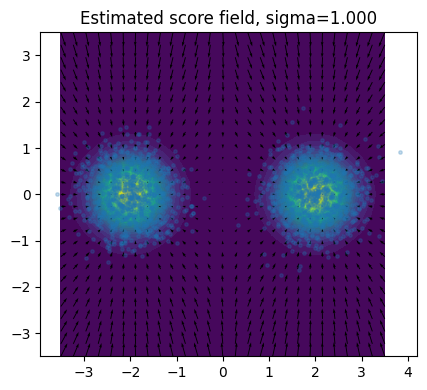

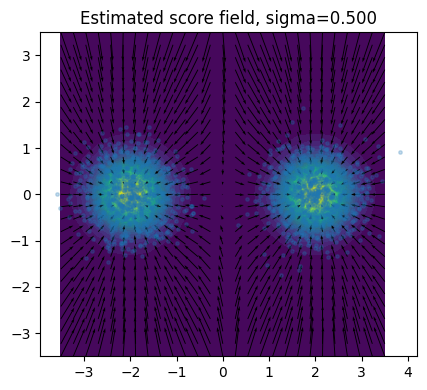

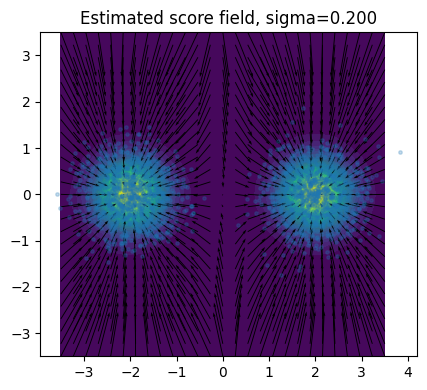

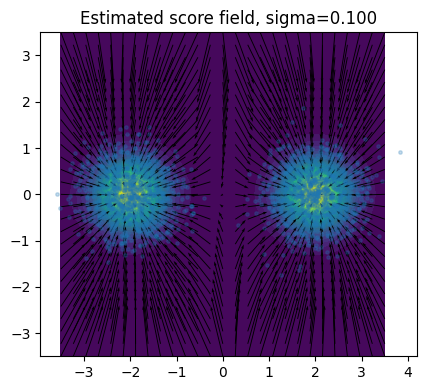

In [20]:
@torch.no_grad()
def plot_score_field(sigmas, lim=3.5, grid_n=25):
    xs = np.linspace(-lim, lim, grid_n)
    ys = np.linspace(-lim, lim, grid_n)
    Xg, Yg = np.meshgrid(xs, ys)
    grid = np.stack([Xg.ravel(), Yg.ravel()], axis=1)
    grid_t = torch.tensor(grid, dtype=torch.float32, device=device)

    # true density for background
    lp = log_mixture(grid_t).cpu().numpy().reshape(grid_n, grid_n)

    for s_val in sigmas:
        sigma_t = torch.full((grid_t.size(0),), float(s_val), device=device)
        s_est = score_net(grid_t, sigma_t).cpu().numpy()
        U = s_est[:,0].reshape(grid_n, grid_n)
        V = s_est[:,1].reshape(grid_n, grid_n)

        plt.figure(figsize=(5,4))
        plt.contourf(Xg, Yg, np.exp(lp - lp.max()), levels=30)  # normalized for display
        plt.quiver(Xg, Yg, U, V, angles='xy', scale_units='xy', scale=10)
        plt.scatter(x_demo[:,0], x_demo[:,1], s=6, alpha=0.25)
        plt.title(f"Estimated score field, sigma={s_val:.3f}")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.tight_layout(); plt.show()

plot_score_field(sigmas=[1.0, 0.5, 0.2, 0.1], lim=3.5, grid_n=27)

## 6) Langevin sampling at fixed sigma (samples approximate q_sigma)

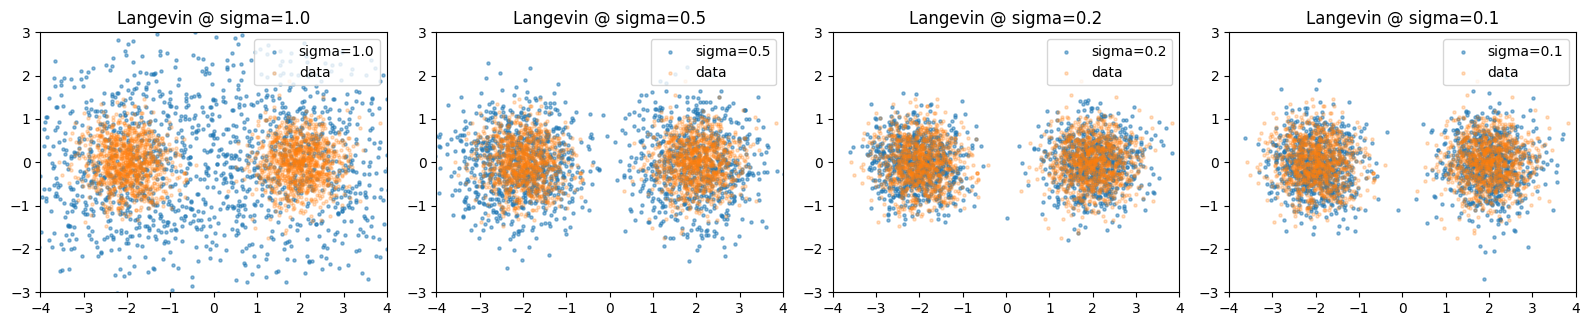

In [22]:
@torch.no_grad()
def langevin_fixed_sigma(n=2000, sigma=0.5, steps=150, step_size=None):
    # Samples from the smoothed density q_sigma via Langevin dynamics
    if step_size is None:
        step_size = 0.5 * sigma**2
    x = torch.randn(n, 2, device=device) * 2.0  # init wide
    sig = torch.full((n,), float(sigma), device=device)
    for _ in range(steps):
        x = x + step_size * score_net(x, sig) + torch.sqrt(torch.tensor(2*step_size, device=device)) * torch.randn_like(x)
    return x

def plot_langevin_sigmas(sigmas, n=2000, steps=100):
    cols = len(sigmas)
    plt.figure(figsize=(4*cols,4))
    for i, s in enumerate(sigmas):
        x_samp = langevin_fixed_sigma(n=n, sigma=s, steps=steps).cpu().numpy()
        ax = plt.subplot(1, cols, i+1)
        ax.scatter(x_samp[:,0], x_samp[:,1], s=5, alpha=0.5, label=f"sigma={s}")
        ax.scatter(x_demo[:,0], x_demo[:,1], s=5, alpha=0.25, label="data")
        ax.set_title(f"Langevin @ sigma={s}")
        ax.set_xlim(-4,4); ax.set_ylim(-3,3); ax.set_aspect('equal', adjustable='box')
        ax.legend(loc="upper right")
    plt.tight_layout(); plt.show()

plot_langevin_sigmas(sigmas=[1.0, 0.5, 0.2, 0.1], n=1500, steps=120)

## 7) Annealed Langevin Dynamics (ALD) with sigma ladder

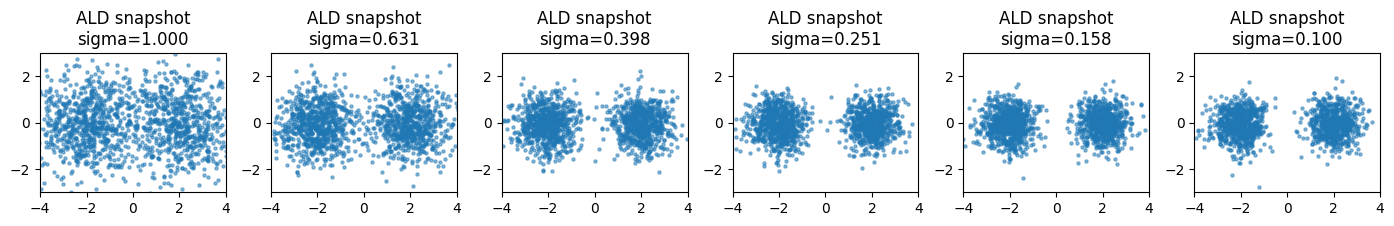

In [ ]:
@torch.no_grad()
def annealed_langevin(n=2000, sigmas=None, steps_per_sigma=150, step_coef=0.05):
    if sigmas is None:
        sigmas = np.geomspace(1.0, 0.05, 10)  # high to low
    x = torch.randn(n, 2, device=device) * 2.0
    traj = []  # store snapshots
    for s in sigmas:
        sig = torch.full((n,), float(s), device=device)
        step_size = (step_coef * (s**2)).astype('float32')
        for _ in range(steps_per_sigma):
            x = x.to(torch.float32) + step_size * score_net(x, sig).to(torch.float32) + torch.sqrt(torch.tensor(2*step_size, device=device).to(torch.float32)).to(torch.float32) torch.randn_like(x).to(torch.float32)
        traj.append(x.detach().cpu().numpy())
    return sigmas, traj

sigmas, traj = annealed_langevin(n=1500, sigmas=np.geomspace(1.0, 0.1, 6), steps_per_sigma=80, step_coef=0.05)

# Plot snapshots
plt.figure(figsize=(14,4))
for i, (s, xs) in enumerate(zip(sigmas, traj)):
    ax = plt.subplot(1, len(sigmas), i+1)
    ax.scatter(xs[:,0], xs[:,1], s=5, alpha=0.5)
    ax.set_title(f"ALD snapshot\nsigma={s:.3f}")
    ax.set_xlim(-4,4); ax.set_ylim(-3,3); ax.set_aspect('equal', adjustable='box')
plt.tight_layout(); plt.show()

## 8) Notes
- **DSM target:** \(s_\theta(\tilde x,\sigma) \approx \nabla_{\tilde x}\log q_\sigma(\tilde x)\).
- **Fixed-\(\sigma\) Langevin** samples from the **smoothed** density \(q_\sigma\).
- **ALD** gradually reduces \(\sigma\), sharpening samples toward the data distribution.
- The score network conditions on \(\log\sigma\); richer embeddings (Fourier features) can improve quality.
- Try different mixture parameters, sigma ladders, and step sizes for varied behavior.